# Problem Set 5 (Total points: 110 + bonus 50)
# Support Vector Machines

In this problem set you will implement an SVM and fit it using quadratic programming. We will use the CVXOPT module to solve the optimization problems.<br>
You may want to start with solving the written problems at the end of this notebook or at least with reading the textbook. It will help a lot in this programming assignment.<br>
Some of the cells will take minutes to run, so feel free to test you code on smaller tasks while you go. Easiest way would be to remove both for-loops and run the code just once. 

### Quadratic Programming

The standard form of a QP can be formulated as 
$$
\begin{align}
\min_x\quad &\frac12 x^TPx + q^Tx\\
\text{subject to }\quad & Gx \preceq h\\
& Ax = b
\end{align}
$$
where $\preceq$ is an element-wise $\leq$.
CVXOPT solver finds an optimal solution $x^*$, given a set of matrices $P, q, G, h, A, b$.

FYI, you can read on the methods to solve quadratic programming problems [here](https://en.wikipedia.org/wiki/Quadratic_programming#Solution_methods).

## Problem 1. [10 points]

Design appropriate matrices to solve the following problem.
$$
\begin{align}
\min_x\quad &f(x)=x_1^2 + 4x_2^2-8x_1-16x_2\\
\text{subject to }\quad & x_1+x_2\leq 5\\
& x_1 \leq 3\\
& x_2 \geq 0
\end{align}
$$

In [44]:
# run the code if the library is not installed
!pip install cvxopt

In [45]:
from cvxopt import matrix, solvers
# Turns off the printing of CVXOPT solution for the rest of the notebook
solvers.options['show_progress'] = False

P = 2 * matrix([[1., 0.], [0., 4.]])
#------------------------------------------------------------------------------------------
# Define q, G, h
q = matrix([-8.0,-16.0])
G = matrix([[1.0,1.0,0.0],[1.0,0.0,-1.0]])
h = matrix([5.0,3.0,0.0])
#------------------------------------------------------------------------------------------

sol = solvers.qp(P, q, G, h)
x1, x2 = sol['x']
print('Optimal x: ({:.8f}, {:.8f})'.format(x1, x2))

Optimal x: (2.99999993, 1.99927914)


Let's visualize the solution

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


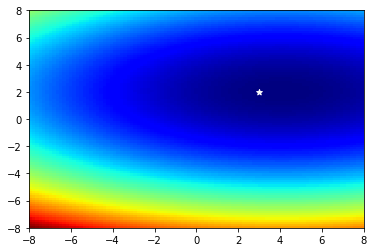

In [46]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

X1, X2 = np.meshgrid(np.linspace(-8, 8, 100), np.linspace(-8, 8, 100))
F = X1**2 + 4*X2**2 - 8*X1 - 16 * X2

plt.pcolor(X1, X2, F, cmap='jet')
plt.scatter([x1], [x2], marker='*', color='white')
plt.show()

Why is the solution not in the minimum?

### Linear SVM

Now, let's implement linear SVM. We will do this for a general case, that allows class distributions to overlap **(see Bishop 7.1.1)**.

As a linear model, linear SVM produces classification scores for a given sample $x$ as
$$
 \hat y(x) = w^T\phi(x) + b
$$
where $w\in\mathbb{R}^d$, $b\in\mathbb{R}$ are model weights and bias, respectively, and $\phi$ is a fixed feature-space transformation. Final label prediction is done by taking the sign of $\hat y(x)$.

Given a set of training samples $x_n\in\mathbb{R}^d$, $n\in 1,\ldots, N$, with the corresponding labels $y_i\in\{-1, 1\}$ linear SVM is fit (*i.e.* parameters $w$ and $b$ are chosen) by solving the following constrained optimization task:
$$
\begin{align}
    \min_{w, \xi, b}\quad & \frac12||w||^2 + C\sum_{n=1}^N \xi_n\\
    \text{subject to }\quad & y_n\hat y(x_n) \geq 1 - \xi_n, & n=1,\ldots, N\\
    & \xi_n \geq 0, & n=1,\ldots, N
\end{align}
$$

## Problem 2.1 [60 points]
Your task is to implement this using a QP solver by designing appropriate matrices $P$, $q$, $G$, $h$.

##### Hints
1. You need to optimize over $w, \xi, b$. You can simply concatenate them into $\chi = (w, \xi, b)$ to feed it into QP-solver. Now, how to define the objective function and the constraints in terms of $\chi$? (For example, $b_1 + b_2$ can be obtained from vector $(a_1, b_1, b_2, c_1, c_2)$ by taking the inner product with $(0, 1, 1, 0, 0)$).
3. You can use `np.bmat` to construct matrices. Like this:

In [47]:
np.bmat([[np.identity(3), np.zeros((3, 1))],
         [np.zeros((2, 3)), -np.ones((2, 1))]])

matrix([[ 1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0., -1.],
        [ 0.,  0.,  0., -1.]])

In [61]:
from sklearn.base import BaseEstimator

class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform
        
    def fit(self, X, Y):
        """Fit Linear SVM using training dataset (X, Y).
        
        :param X: data samples of shape (N, d).
        :param Y: data target labels of size (N). Each label is either 1 or -1.
        """
        # Apply transformation (phi) to X
        if self.transform is not None:
            X = self.transform(X)
        d = len(X[0])
        N = len(X)
        
        #------------------------------------------------------------------------------------------
        # Construct appropriate matrices here to solve the optimization problem described above.
        # We want optimal solution for vector (w, xi, b). 
        P = matrix(np.bmat([[np.identity(d), np.zeros((d, N + 1))], 
                            [np.zeros((N + 1, d)), np.zeros((N + 1, N + 1))]]))
        q = matrix(np.bmat([[np.zeros((d,1))], 
                            [self.C * np.ones((N,1))], 
                            [np.zeros((1,1))]]))
        G = matrix(np.bmat([[-np.dot(np.diag(Y), X), -np.identity(N), -np.array(Y).reshape((N, 1))], 
                            [np.zeros((N, d)), -np.identity(N), np.zeros((N, 1))]]))
        h = matrix(np.bmat([[-np.ones((N,1))],
                            [np.zeros((N,1))]]))
        #------------------------------------------------------------------------------------------
        
        sol = solvers.qp(P, q, G, h)
        ans = np.array(sol['x']).flatten()
        self.weights_ = ans[:d]
        self.xi_ = ans[d:d+N]
        self.bias_ = ans[-1]
        
        #------------------------------------------------------------------------------------------
        # Find support vectors. Must be a boolean array of length N having True for support
        # vectors and False for the rest.
        self.support_vectors = self.xi_ > 1e-5
        #------------------------------------------------------------------------------------------
        
    def predict_proba(self, X):
        """
        Make real-valued prediction for some new data.
        :param X: data samples of shape (N, d).
        :return: an array of N predicted scores.
        """
        # return y_hat
        if self.transform is not None:
            X = self.transform(X)
        return np.dot(X, self.weights_) + self.bias_

    def predict(self, X):
        """
        Make binary prediction for some new data.
        :param X: data samples of shape (N, d).
        :return: an array of N binary predicted labels from {-1, 1}.
        """
        return np.sign(self.predict_proba(X))

Let's see how our LinearSVM performs on some data.

In [62]:



from sklearn.datasets import make_classification, make_circles
X = [None, None, None]
y = [None, None, None]
X[0], y[0] = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=1)
X[1], y[1] = make_circles(n_samples=100, factor=0.5)
X[2], y[2] = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=4)

# Go from {0, 1} to {-1, 1}
y = [2 * yy - 1 for yy in y]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: No contour levels were found within the data range.


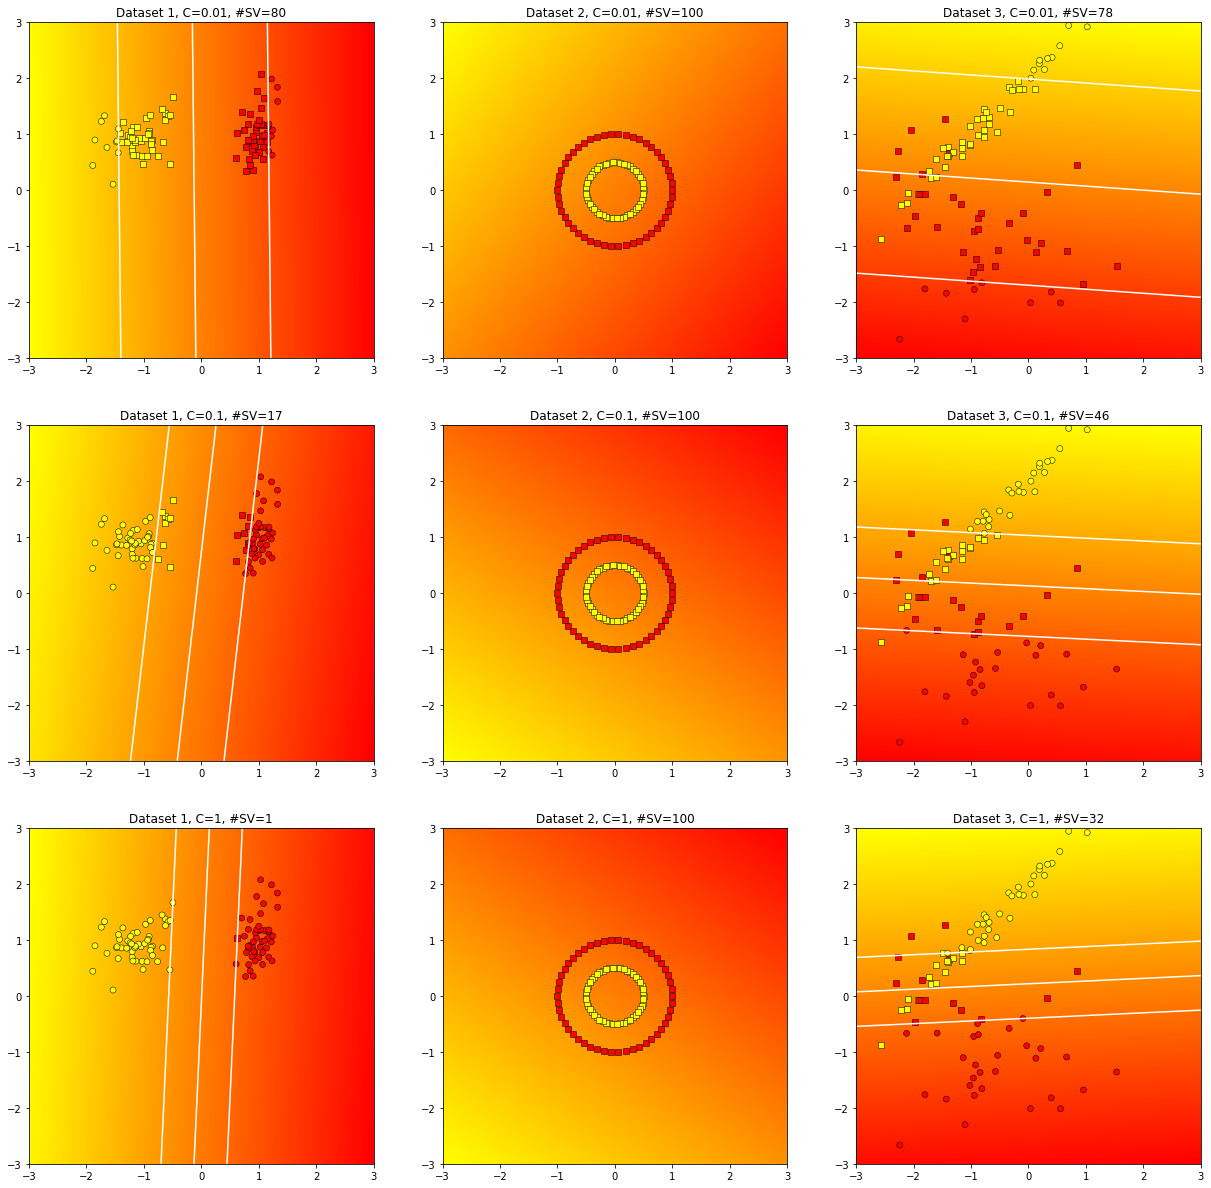

In [63]:
C_values = [0.01, 0.1, 1]

plot_i = 0
plt.figure(figsize=(len(X) * 7, len(C_values) * 7))
for C in C_values:
    for i in range(len(X)):
        plot_i += 1
        plt.subplot(len(C_values), len(X), plot_i)
        #----------------------------------------------------------------------------
        model = LinearSVM(C=C)
        #----------------------------------------------------------------------------
        model.fit(X[i], y[i])
        sv = model.support_vectors
        n_sv = sv.sum()
        if n_sv > 0:
            plt.scatter(X[i][:, 0][sv], X[i][:, 1][sv], c=y[i][sv], cmap='autumn', marker='s',
                        linewidths=0.5, edgecolors=(0, 0, 0, 1))
        if n_sv < len(X[i]):
            plt.scatter(X[i][:, 0][~sv], X[i][:, 1][~sv], c=y[i][~sv], cmap='autumn',
                        linewidths=0.5, edgecolors=(0, 0, 0, 1))
        xvals = np.linspace(-3, 3, 200)
        yvals = np.linspace(-3, 3, 200)
        xx, yy = np.meshgrid(xvals, yvals)
        zz = np.reshape(model.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
        plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)
        plt.contour(xx, yy, zz, levels=(-1, 0, 1,), colors='w', linewidths=1.5, zorder=1, linestyles='solid')

        plt.xlim([-3, 3])
        plt.ylim([-3, 3])
        plt.title('Dataset {}, C={}, #SV={}'.format(i + 1, C, n_sv))
plt.show()

Why does the number of support vectors decrease as $C$ increases?

For debug purposes. Very last model must have almost the same weights and bias:
$$w = \begin{pmatrix}-0.0784521\\ 1.62264867\end{pmatrix}$$
$$b = -0.3528510092782581$$

In [51]:
model.weights_

array([-0.0784521 ,  1.62264867])

In [52]:
model.bias_

-0.3528510092782581

## Problem 2.2 [10 points]

Even using a linear SVM, we are able to separate data that is linearly inseparable by using feature transformation.

Implement the following feature transformation
$
    \phi(x_1, x_2) = (x_1,\ x_2,\ x_1^2,\ x_2^2,\ x_1x_2)
$

In [53]:
def append_second_order(X):
    """Given array Nx[x1, x2] return Nx[x1, x2, x1^2, x2^2, x1x2]."""
    # return new_X
    # concatenate more feautres together
    X_1 = np.reshape(X[:,0],[-1,1])
    X_2 = np.reshape(X[:,1],[-1,1])
    return np.concatenate((X_1, X_2, X_1*X_1, X_2*X_2, X_1*X_2), axis=1)

assert np.all(append_second_order(np.array([[1, 2]])) == np.array([[1, 2, 1, 4, 2]])), 'Transformation is incorrect.'

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


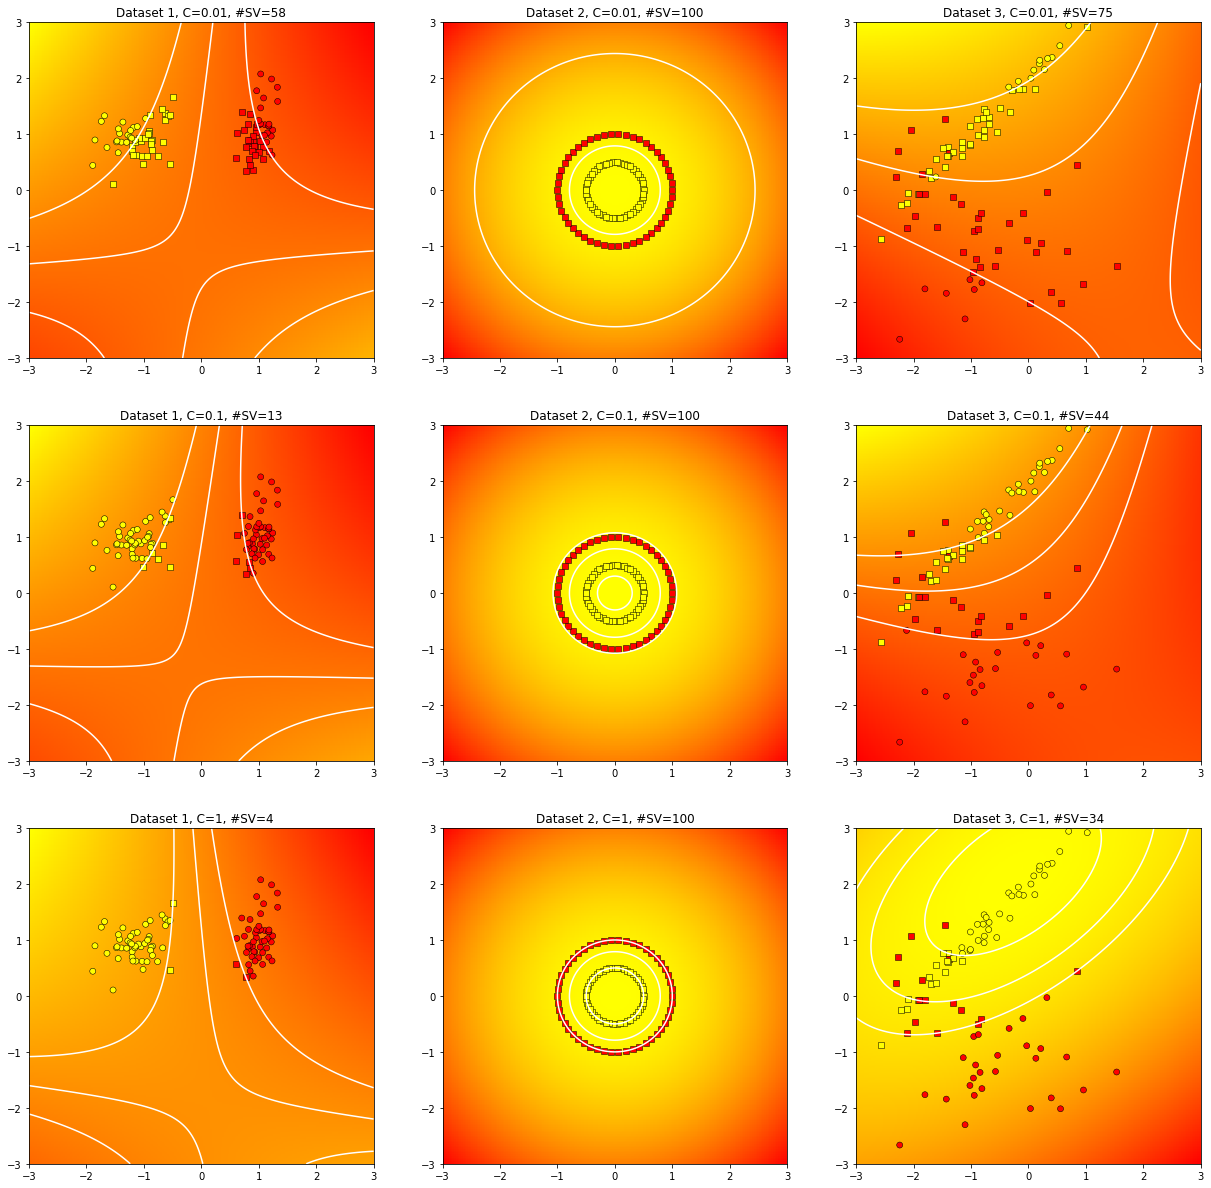

In [54]:
plot_i = 0
C_values = [0.01, 0.1, 1]
plt.figure(figsize=(len(X) * 7, len(C_values) * 7))
for C in C_values:
    for i in range(len(X)):
        plot_i += 1
        plt.subplot(len(C_values), len(X), plot_i)
        #----------------------------------------------------------------------------
        model = LinearSVM(C=C, transform=append_second_order)
        #----------------------------------------------------------------------------
        model.fit(X[i], y[i])
        sv = model.support_vectors
        n_sv = sv.sum()
        if n_sv > 0:
            plt.scatter(X[i][:, 0][sv], X[i][:, 1][sv], c=y[i][sv], cmap='autumn', marker='s',
                        linewidths=0.5, edgecolors=(0, 0, 0, 1))
        if n_sv < len(X[i]):
            plt.scatter(X[i][:, 0][~sv], X[i][:, 1][~sv], c=y[i][~sv], cmap='autumn',
                        linewidths=0.5, edgecolors=(0, 0, 0, 1))
        xvals = np.linspace(-3, 3, 200)
        yvals = np.linspace(-3, 3, 200)
        xx, yy = np.meshgrid(xvals, yvals)
        zz = np.reshape(model.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
        plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)
        plt.contour(xx, yy, zz, levels=(-1, 0, 1,), colors='w', linewidths=1.5, zorder=1, linestyles='solid')

        plt.xlim([-3, 3])
        plt.ylim([-3, 3])
        plt.title('Dataset {}, C={}, #SV={}'.format(i + 1, C, n_sv))
plt.show()

# Bonus part (Optional)

## Dual representation. Kernel SVM

The dual representation of the maximum margin problem is given by
$$
\begin{align}
    \max_{\alpha}\quad & \sum_{n=1}^N\alpha_n - \frac12\sum_{n=1}^N\sum_{m=1}^N\alpha_n\alpha_my_ny_mk(x_n, x_m)\\
    \text{subject to }\quad & 0 \leq \alpha_n \leq C,\quad n=1,\ldots, N\\
    & \sum_{n=1}^N\alpha_ny_n = 0
\end{align}
$$
In this case bias $b$ can be computed as
$$
    b = \frac{1}{|\mathcal{S}|}\sum_{n\in \mathcal{S}}\left(y_n - \sum_{m\in \mathcal{S}}\alpha_my_mk(x_n, x_m)\right),
$$
and the prediction turns into
$$
    \hat{y}(x) = \sum_{n\in \mathcal{S}}\alpha_ny_nk(x_n, x) + b.
$$

Everywhere above $k$ is a kernel function: $k(x_1, x_2)=\phi(x_1)^T\phi(x_2)$ (and the trick is that we don't have to specify $\phi$, just $k$).

Note, that now
1. We want to maximize the objective function, not minimize it.
2. We have equality constraints. (That means we should use $A$ and $b$ in qp-solver)
3. We need access to the support vectors (but not all the training samples) in order to make a prediction.

## Problem 3.1 [40 points]
Implement KernelSVM

##### Hints
1. What is the variable we are optimizing over?
2. How can we maximize a function given a tool for minimization?
3. What is the definition of a support vector in the dual representation?

In [55]:
class KernelSVM(BaseEstimator):
    def __init__(self, C, kernel=np.dot):
        self.C = C
        self.kernel = kernel
        
    def fit(self, X, Y):
        """Fit Kernel SVM using training dataset (X, Y).
        
        :param X: data samples of shape (N, d).
        :param Y: data target labels of size (N). Each label is either 1 or -1. Denoted as t_i in Bishop.
        """
        N = len(Y)
        
        #------------------------------------------------------------------------------------------
        # Construct appropriate matrices here to solve the optimization problem described above.
        P = matrix([Y[i] * Y[j] * self.kernel(X[i], X[j]) for i in range(N) for j in range(N)], (N, N))
        q = matrix(-np.ones(N))
        G = matrix(np.bmat([[-1. * np.identity(N)], 
                            [1. * np.identity(N)]]))
        h = matrix([0.] * N + [self.C] * N)
        A = matrix(1. * Y, (1, N))
        b = matrix(0.)
        #------------------------------------------------------------------------------------------

        sol = solvers.qp(P, q, G, h, A, b)
        self.alpha_ = np.array(sol['x']).flatten()
        
        #------------------------------------------------------------------------------------------
        # Find support vectors. Must be a boolean array of length N having True for support
        # vectors and False for the rest.
        self.support_vectors = self.alpha_ > 1e-5
        #------------------------------------------------------------------------------------------
        
        sv_ind = self.support_vectors.nonzero()[0]
        self.X_sup = X[sv_ind]
        self.Y_sup = Y[sv_ind]
        self.alpha_sup = self.alpha_[sv_ind]
        self.n_sv = len(sv_ind)
        
        #------------------------------------------------------------------------------------------
        # Compute bias
        self.bias_ = np.mean([self.Y_sup[i] - np.sum([self.alpha_sup[j] * self.Y_sup[j] * self.kernel(self.X_sup[i], self.X_sup[j]) for j in range(self.n_sv)]) for i in range(self.n_sv)]) 
        #------------------------------------------------------------------------------------------
        
    def predict_proba(self, X):
        """
        Make real-valued prediction for some new data.
        :param X: data samples of shape (N, d).
        :return: an array of N predicted scores.
        """
        # return y_hat
        return [np.sum([self.alpha_sup[i] * self.Y_sup[i] * self.kernel(self.X_sup[i], X[j]) for i in range(self.n_sv)]) + self.bias_ for j in range(len(X))]
            
    def predict(self, X):
        """
        Make binary prediction for some new data.
        :param X: data samples of shape (N, d).
        :return: an array of N binary predicted labels from {-1, 1}.
        """
        return np.sign(self.predict_proba(X))

We can first test our implementation by using the dot product as a kernel function. What should we expect in this case?

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


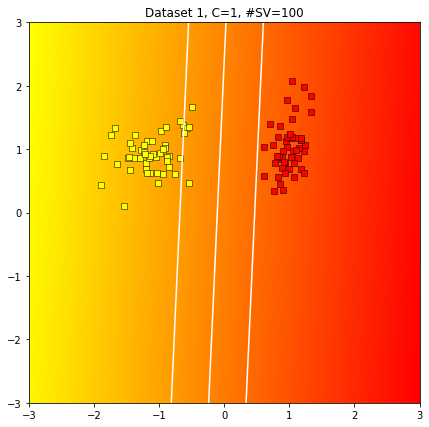

In [56]:
C = 1
i = 0

plt.figure(figsize=(7, 7))
#----------------------------------------------------------------------------
model = KernelSVM(C=C, kernel=np.dot)
#----------------------------------------------------------------------------
model.fit(X[i], y[i])
sv = model.support_vectors
n_sv = sv.sum()
if n_sv > 0:
    plt.scatter(X[i][:, 0][sv], X[i][:, 1][sv], c=y[i][sv], cmap='autumn', marker='s',
                linewidths=0.5, edgecolors=(0, 0, 0, 1))
if n_sv < len(X[i]):
    plt.scatter(X[i][:, 0][~sv], X[i][:, 1][~sv], c=y[i][~sv], cmap='autumn',
                linewidths=0.5, edgecolors=(0, 0, 0, 1))
xvals = np.linspace(-3, 3, 200)
yvals = np.linspace(-3, 3, 200)
xx, yy = np.meshgrid(xvals, yvals)
zz = np.reshape(model.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)
plt.contour(xx, yy, zz, levels=(-1, 0, 1,), colors='w', linewidths=1.5, zorder=1, linestyles='solid')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.title('Dataset {}, C={}, #SV={}'.format(i + 1, C, n_sv))
plt.show()

## Problem 3.2 [5 points]
Implement a polynomial kernel function ([wiki](https://en.wikipedia.org/wiki/Polynomial_kernel)).

In [57]:
def polynomial_kernel(d, c=0):
    """Returns a polynomial kernel FUNCTION."""
    def kernel(x, y):
        """
        :param x: vector of size L
        :param y: vector of size L
        :return: [polynomial kernel of degree d with bias parameter c] of x and y. A scalar.
        """
        return (np.dot(x, y) + c) ** d
    return kernel

assert polynomial_kernel(d=2, c=1)(np.array([1, 2]), np.array([3, 4])) == 144, 'Polynomial kernel implemented incorrectly'

Let's see how it performs. This might take some time to run.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


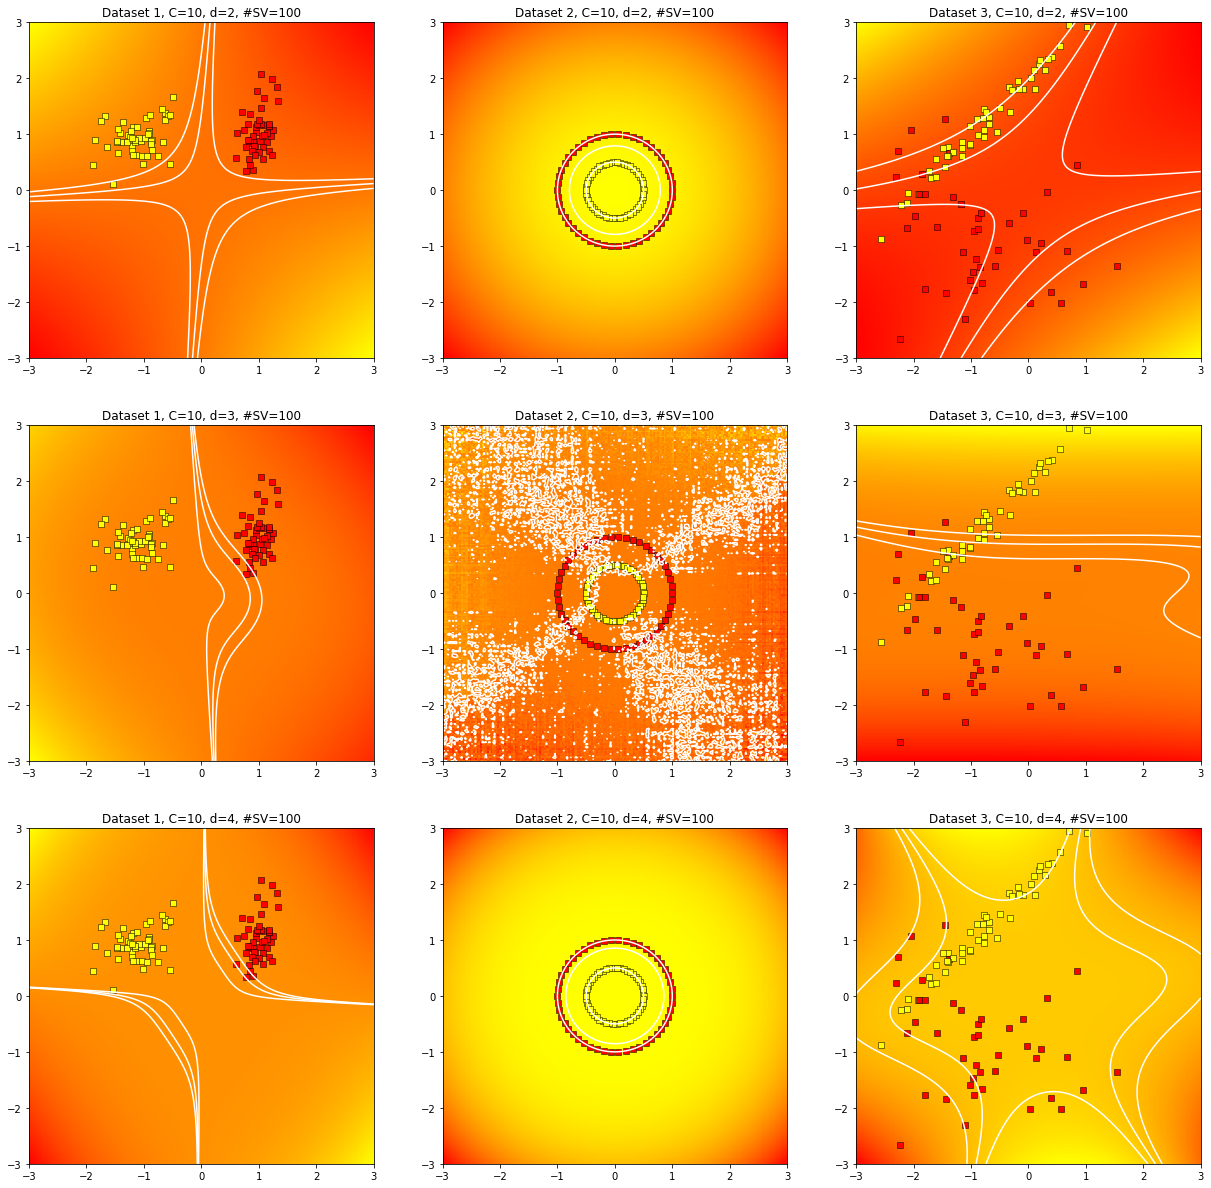

In [58]:
plot_i = 0
C = 10
d_values = [2, 3, 4]
plt.figure(figsize=(len(X) * 7, len(d_values) * 7))
for d in d_values:
    for i in range(len(X)):
        plot_i += 1
        plt.subplot(len(d_values), len(X), plot_i)
        #----------------------------------------------------------------------------
        model = KernelSVM(C=C, kernel=polynomial_kernel(d))
        #----------------------------------------------------------------------------
        model.fit(X[i], y[i])
        sv = model.support_vectors
        n_sv = sv.sum()
        if n_sv > 0:
            plt.scatter(X[i][:, 0][sv], X[i][:, 1][sv], c=y[i][sv], cmap='autumn', marker='s',
                        linewidths=0.5, edgecolors=(0, 0, 0, 1))
        if n_sv < len(X[i]):
            plt.scatter(X[i][:, 0][~sv], X[i][:, 1][~sv], c=y[i][~sv], cmap='autumn',
                        linewidths=0.5, edgecolors=(0, 0, 0, 1))
        xvals = np.linspace(-3, 3, 200)
        yvals = np.linspace(-3, 3, 200)
        xx, yy = np.meshgrid(xvals, yvals)
        zz = np.reshape(model.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
        plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)
        plt.contour(xx, yy, zz, levels=(-1, 0, 1,), colors='w', linewidths=1.5, zorder=1, linestyles='solid')

        plt.xlim([-3, 3])
        plt.ylim([-3, 3])
        plt.title('Dataset {}, C={}, d={}, #SV={}'.format(i + 1, C, d, n_sv))

## Task 3.3 [5 points]
Finally, you need to implement a **radial basis function** kernel ([wiki](https://en.wikipedia.org/wiki/Radial_basis_function_kernel)).

In [59]:
def RBF_kernel(sigma):
    """Returns an RBF kernel FUNCTION."""
    def kernel(x, y):
        """
        :param x: vector of size L
        :param y: vector of size L
        :return: [rbf kernel with parameter sigma] of x and y. A scalar.
        """
        return np.exp(-np.sum((x - y)**2) / (2 * sigma**2))
    return kernel

Let's see how it performs. This might take some time to run.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


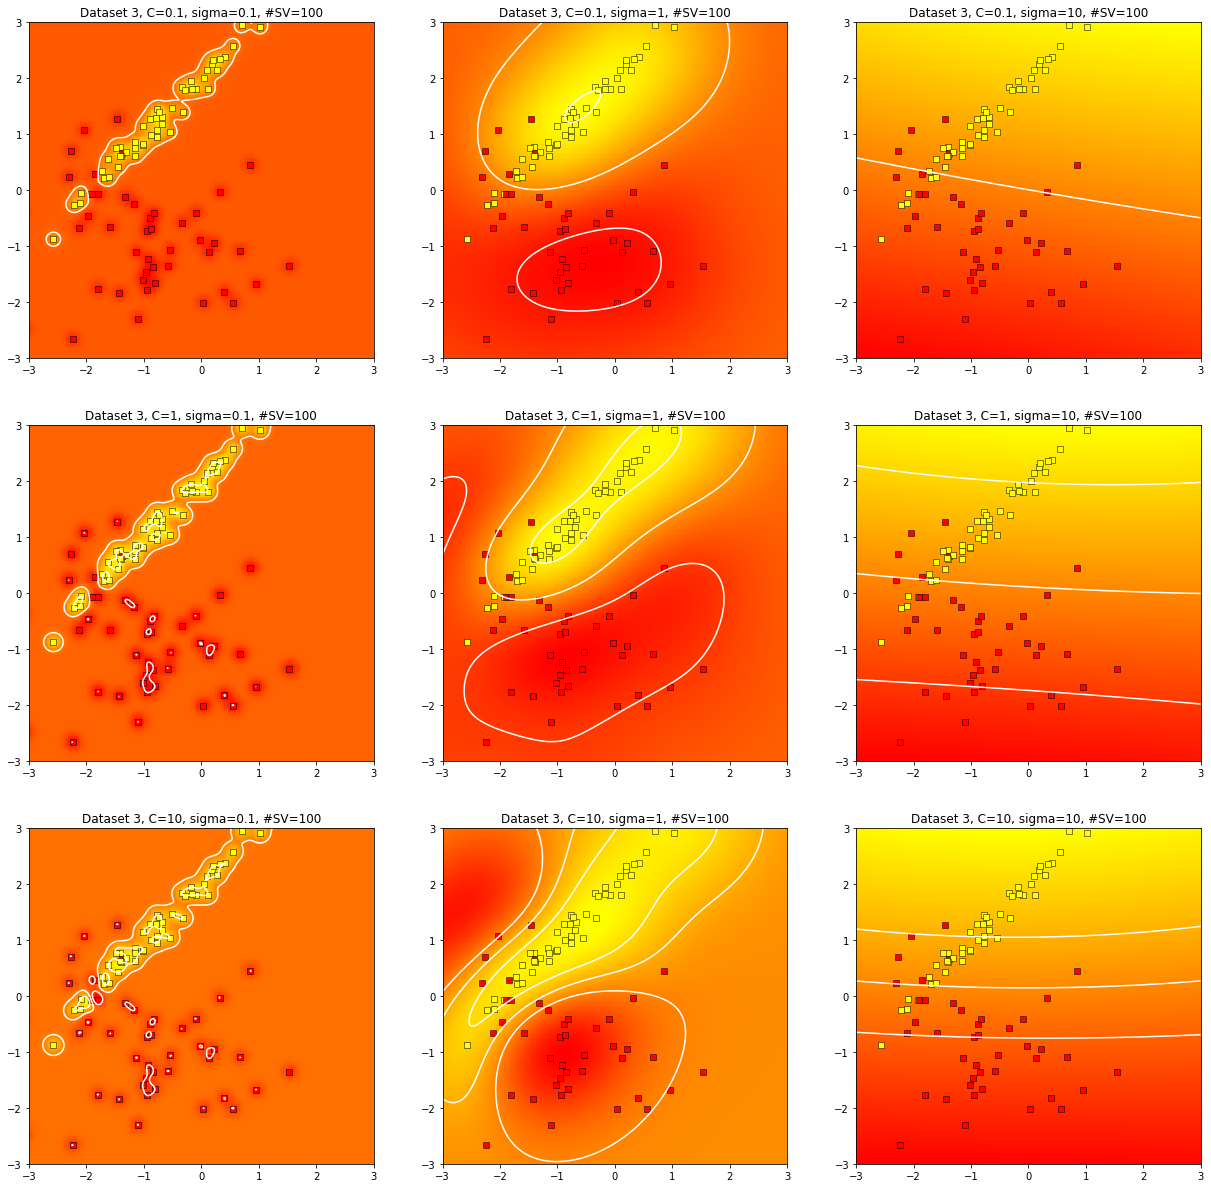

In [60]:
plot_i = 0
C_values = [0.1, 1, 10]
sigma_values = [0.1, 1, 10]
plt.figure(figsize=(len(sigma_values) * 7, len(C_values) * 7))
i = 2
for C in C_values:
    for sigma in sigma_values:
        plot_i += 1
        plt.subplot(len(C_values), len(X), plot_i)
        model = KernelSVM(C=C, kernel=RBF_kernel(sigma))
        model.fit(X[i], y[i])
        sv = model.support_vectors
        n_sv = sv.sum()
        if n_sv > 0:
            plt.scatter(X[i][:, 0][sv], X[i][:, 1][sv], c=y[i][sv], cmap='autumn', marker='s',
                        linewidths=0.5, edgecolors=(0, 0, 0, 1))
        if n_sv < len(X[i]):
            plt.scatter(X[i][:, 0][~sv], X[i][:, 1][~sv], c=y[i][~sv], cmap='autumn',
                        linewidths=0.5, edgecolors=(0, 0, 0, 1))
        xvals = np.linspace(-3, 3, 200)
        yvals = np.linspace(-3, 3, 200)
        xx, yy = np.meshgrid(xvals, yvals)
        zz = np.reshape(model.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
        plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)
        plt.contour(xx, yy, zz, levels=(-1, 0, 1,), colors='w', linewidths=1.5, zorder=1, linestyles='solid')

        plt.xlim([-3, 3])
        plt.ylim([-3, 3])
        plt.title('Dataset {}, C={}, sigma={}, #SV={}'.format(i + 1, C, sigma, n_sv))

## Well done!

Awesome! Now you understand all of the important parameters in SVMs. Have a look at SVM from scikit-learn module and how it is used (very similar to ours). 

In [17]:
from sklearn.svm import SVC
SVC?

Init signature: SVC(C=1.0, kernel='rbf', degree=3, gamma='auto_deprecated', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', random_state=None)
Docstring:     
C-Support Vector Classification.

The implementation is based on libsvm. The fit time complexity
is more than quadratic with the number of samples which makes it hard
to scale to dataset with more than a couple of 10000 samples.

The multiclass support is handled according to a one-vs-one scheme.

For details on the precise mathematical formulation of the provided
kernel functions and how `gamma`, `coef0` and `degree` affect each
other, see the corresponding section in the narrative documentation:
:ref:`svm_kernels`.

Read more in the :ref:`User Guide <svm_classification>`.

Parameters
----------
C : float, optional (default=1.0)
    Penalty parameter C of the error term.

kernel : string, optional (default='rbf')
    Specifies 

C:\miniconda\envs\cvx\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


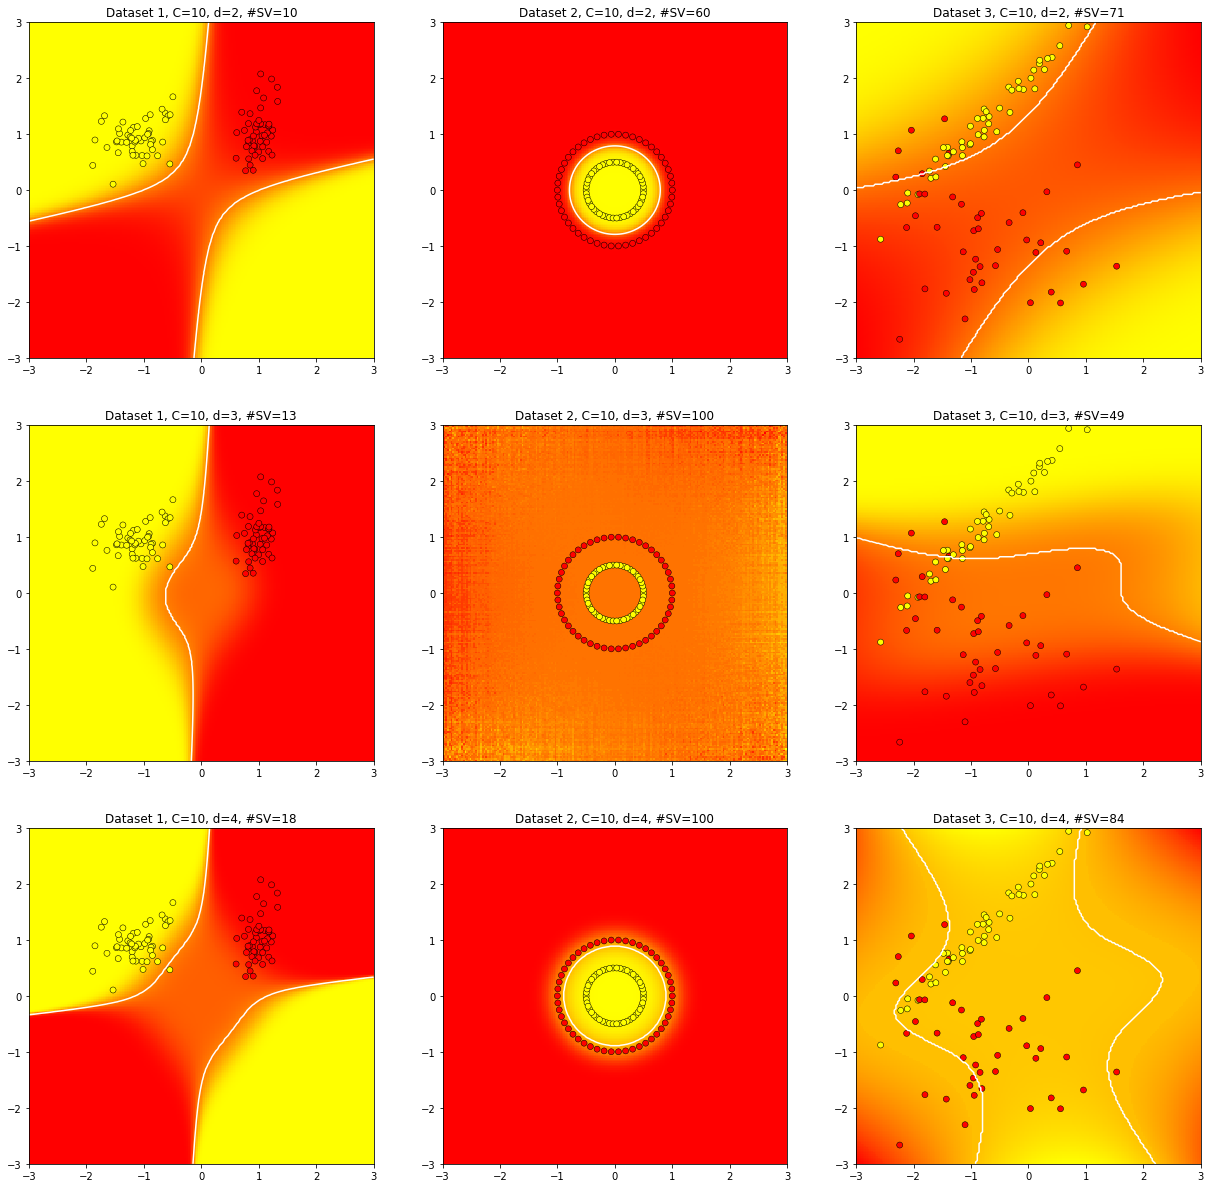

In [18]:
plot_i = 0
C = 10
d_values = [2, 3, 4]
plt.figure(figsize=(len(X) * 7, len(d_values) * 7))
for d in d_values:
    for i in range(len(X)):
        plot_i += 1
        plt.subplot(len(d_values), len(X), plot_i)
        #----------------------------------------------------------------------------
        model = SVC(kernel='poly', degree=d, gamma='auto', probability=True)
        #----------------------------------------------------------------------------
        model.fit(X[i], y[i])
        plt.scatter(X[i][:, 0], X[i][:, 1], c=y[i], cmap='autumn', linewidths=0.5, edgecolors=(0, 0, 0, 1))
        xvals = np.linspace(-3, 3, 200)
        yvals = np.linspace(-3, 3, 200)
        xx, yy = np.meshgrid(xvals, yvals)
        zz = np.reshape(model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1] * 2 - 1, xx.shape)
        plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)
        plt.contour(xx, yy, zz, levels=(-1., 0., 1.), colors='w', linewidths=1.5, zorder=1, linestyles='solid')

        plt.xlim([-3, 3])
        plt.ylim([-3, 3])
        plt.title('Dataset {}, C={}, d={}, #SV={}'.format(i + 1, C, d, len(model.support_vectors_)))

# 4 Written Problems

## Problem 4.1 Dual Representations [10 pts]
Read section 6.1 in Bishop, and work through all of the steps of the derivations in equations 6.2-6.9. You should understand how the derivation works in detail. Write down your understanding.

The dual representation is a computational trick that allows least square problem to be expressed entirely in terms of kernel function. Consider the following error function:
$$ J(\text w) = \frac{1}{2}\sum_{n=1}^N \{\text w^T\phi(x_n)-t_n\}^2+\frac{\lambda}{2}\text w^T \text w $$
If we set the gradient of $J(\text w)$ w.r.t w equal to zero, we see the solution for w of the form:
$$ \nabla_{\text w} J(\text w) = \sum_{n=1}^N \{\text w^T \phi(x_n)-t_n \} \phi(x_n)+\lambda \text w = 0 $$
$$ \text w = -\frac{1}{\lambda}\sum_{n=1}^N \{\text w^T \phi(x_n)-t_n \}\phi(x_n) = \sum_{n=1}^N a_n\phi(x_n) = \Phi^T a$$
where $\Phi$ is the design matrix. The vector $a = (a_1,...,a_N)^T$, and we've defined
$$ a_n = -\frac{1}{\lambda}\{\text w^T \phi(x_n)-t_n \}$$
If we substitute $\text w = \Phi^T a$ into $J(\text w)$, we obtain
$$ J(a) = \frac{1}{2}\sum_{n=1}^N \{(a_n \phi(x_n))^T\phi(x_n)-t_n\}^2 + \frac{\lambda}{2}\sum_{n=1}^N (a_n \phi(x_n))^T (a_n \phi(x_n))$$
$$ J(a) = \frac{1}{2}a^T\Phi \Phi^T \Phi \Phi^T a - a^T \Phi \Phi^T t + \frac{1}{2}t^T t + \frac{\lambda}{2}a^T \Phi \Phi^T a $$
We define the kernel matrix $K = \Phi \Phi^T$, which is an $NxN$ symmetric matrix with elements
$$ K_{nm} = \phi(x_n)^T\phi(x_m) = k(x_n,x_m) $$
where k is the kernel function.
Thus, we rewrite the error function as
$$ J(a) = \frac{1}{2}a^T K K a - a^T K t + \frac{1}{2}t^T t + \frac{\lambda}{2}a^T K a $$
Set the gradient w.r.t a to zero, we get the solution
$$ \nabla_a J(a) = K K a - Kt + \lambda K a = 0 $$
$$ a = (K+\lambda I_N)^{-1}t $$
We subsitute this back into the linear regression model, we obtain the following prediction for a new input x
$$ y(x) = \text w^T \phi(x) = a^T \Phi \phi(x) = [(K+\lambda I_N)^{-1}t]^T \Phi \phi(x) = [\Phi \phi(x)]^T (K+\lambda I_N)^{-1}t = k(x)^T (K+\lambda I_N)^{-1}t$$

## Problem 4.2 Kernels [10 pts]

Read Section 6.2 and Verify the results (6.13) and (6.14) for constructing valid kernels.

(6.13)

If $k_1(x,x')$ is a valid kernel, then there must exist a feature vector $\phi(x)$ such that
$$k_1(x,x') = \phi(x)^T\phi(x')$$
It follows that 
$$ ck_1(x,x') = \sqrt{(c)}\phi(x)^T\sqrt{(c)}\phi(x')$$
so that $ck_1(x,x')$ can be expressed as the scalar product of feature vectors, and hence is a valid kernel.

(6.14) 

For (6.14), $k(x,x') = f(x)k_1(x,x')f(x')$, where f(x) is any function of x, f(x) is a scalar.
$$ f(x)k_1(x,x')f(x') = f(x)\phi(x)^T\phi(x')f(x') = (\phi(x)f(x))^T(\phi(x')f(x')) = g(x)g(x')$$
So that the new kernel can be expressed as the scalar product of feature vectors, which is a valid kernel.

## Problem 4.3 Maximum Margin Classifiers [10 pts]
Read section 7.1 and show that, if the 1 on the right hand side of the constraint (7.5) is replaced by some arbitrary constant $\gamma > 0$, the solution for maximum margin hyperplane is unchanged.

$$t_n(w^T \phi(x_n) + b) \geq 1$$

The distance of a point $x_n$ to the decision surface is given by
$$ \frac{t_n y(x_n)}{||w||} = \frac{t_n(w^T \phi(x_n)+b)}{||w||}$$
The maximum magin solution is found by solving
$$ \text{argmax}_{w,b} \{\frac{1}{||w||}\text{min}_n [t_n(w^T\phi(x_n)+b]\}$$
We note that if make a rescaling $w \rightarrow \kappa w$, $b \rightarrow \kappa b$, then the distance from any point $x_n$ to the surface is unchanged. We can set 
$$t_n(w^T \phi(x_n) + b) = \gamma $$
for the point closest to the surface. Then all data points will satisfy the constraints
$$ t_n(w^T \phi(x_n) + b) \geq \gamma $$
In order to solve the constrained optimization problem, we introduce Lagrange multipliers $a_n \geq 0$, giving the Lagrangian function
$$ L(w,b,a) = \frac{1}{2}||w||^2 - \sum_{n=1}^N a_n\{t_n(w^T\phi(x_n)+b)- \gamma \}$$
Setting the derivatives of L(w,b,a) w.r.t w and b to zero, we obtain the following two conditions
$$ w = \sum_{n=1}^N a_n t_n \phi(x_n)$$
$$ 0 = \sum_{n=1}^N a_n t_n $$
which doesn't not contain $\gamma$. So that the solution of maximum margin hyperplane is unchanged.